# FINAL PROJECT

highlight this cell and uncomment the stuff below once we are actually done

<!-- This is an advanced Deep Neural Network (DNN) designed for solving captchas. Our training data originates from the widely recognized cifar-10 dataset, publicly accessible through the University of Toronto.

While contemporary captchas remain confidential for security reasons, we have devised a method to simulate our own versions, albeit with reduced security, utilizing the cifar-10 dataset.

Time permitting, we are also exploring the development of a model capable of solving text-based captchas. -->

I have so far taken the liberty of writing code to get our dataset for the image based captchas, and I have written code to generate the training and testing data in a useable way.

I also have written some basic code for one version of the captcha prediction. There is an issue that must be resolved in the train loop which may involve slightly restructuring the truth data.

If you look through the code I think I did a decent job of commenting so hopefully it makes sense



# Imports and downloading datasets

In [ ]:
!pip install pytesseract pillow

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from torch.utils.data import Dataset, DataLoader
from torch import optim
from tqdm import tqdm
from PIL import Image
import string
from torch.nn.functional import one_hot

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# !rm -r cifar-10-python.tar.gz.1
# !rm -r cifar-10-batches-py
# !rm -r data

In [ ]:
#### DOWNLOAD THE DATASET ####
if not os.path.exists('./cifar-10-python.tar.gz'):
  !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
  !mkdir ./data
  !tar -xzvf cifar-10-python.tar.gz -C ./data
  !mv ./data/cifar-10-batches-py/* ./data/
  !rmdir ./data/cifar-10-batches-py

--2023-12-15 05:58:47--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  75.1MB/s    in 2.2s    

2023-12-15 05:58:50 (75.1 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [ ]:
from google.colab import files
if not os.path.exists('captcha-version-2-images.zip'):
  !pip install -q kaggle
  files.upload()
# !ls -lha kaggle.json
  !mkdir -p ~/.kaggle

  !mv kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

  !kaggle datasets download -d fournierp/captcha-version-2-images

Saving kaggle.json to kaggle.json
 69% 12.0M/17.4M [00:00<00:00, 45.9MB/s]
100% 17.4M/17.4M [00:00<00:00, 62.8MB/s]


# Load Datasets and example image extraction

In [ ]:
class CaptchaDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):
      self.data = torch.from_numpy(numpy_data).float()
      self.labels = torch.from_numpy(numpy_labels).float()
      self.transform = transform
      # breakpoint()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, label


In [ ]:
#### LOADING THE DATASET INTO A DICTIONARY ####
def unpickle(file):
  with open(file, 'rb') as fo:
      dict = pickle.load(fo, encoding='bytes')
  return dict

train_batches = [unpickle(f'data/data_batch_{num}') for num in range(1, 6)]
test_batch = unpickle('data/test_batch')
meta_data = unpickle('data/batches.meta')

#### FORMAT OF THE BATCHES ####
# {
#     b'batch_label': 'training batch x of 5',
#     b'labels' : [numerical labels for each photo (1-9)],
#     b'data': [[]] <- this is an array of all of the photos
#     b'filenames': [array of every filename]
# }

#### FORMAT OF THE META DATA ####
# {
#     b'num_cases_per_batch' : 10000,
#     b'label_names': [array of each label name indexed from 0-9]
#     b'num_vis': 3072
# }

#### SHOW THE CORRESPONDING TEXT LABEL FOR EACH INTEGER ####
meta_data[b'label_names']

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

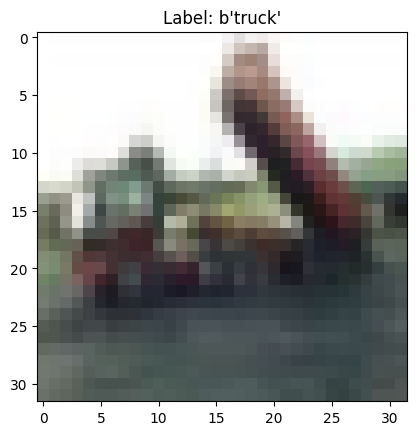

In [ ]:
#### EXAMPLE OF GETTING AN IMAGE OUT ####
images = train_batches[0][b'data']
numerical_labels = train_batches[0][b'labels']
text_label_interpretations = meta_data[b'label_names']

test_image = images[2]
numerical_label = numerical_labels[2]
# The images are flattened into a 1 x 3072 array so test_image is useless as-is
# we first need to reshape them into a 32 x 32 x 3 tensor (a 32 x 32 image with RGB channels)
# then we actually need to swap the 0 and the 1 index (the pics are sideways)
image_reshaped = np.reshape(test_image, (32, 32, 3), order='F')
image_reshaped = np.swapaxes(image_reshaped, 0, 1)

#### NOTE THAT THE QUALITY OF THE IMAGES SUUUUUCKS ####
plt.imshow(image_reshaped)
plt.title(f"Label: {text_label_interpretations[numerical_label]}")
plt.show()

# Create Simulated Captchas

From what I can tell, the images are already shuffled pretty well, so my idea to make the 3x3 grids is just to take 9 images in a row and concatenate them together to make the grids.

I'll show an example of what I mean in the next cell.

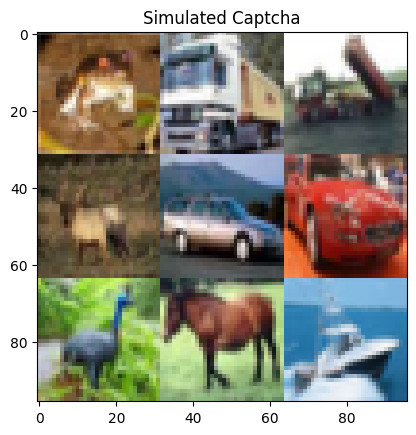

[[b'frog' b'truck' b'truck']
 [b'deer' b'automobile' b'automobile']
 [b'bird' b'horse' b'ship']]


In [ ]:
#### MAKE A SIMULATED CAPTCHA ####
captcha_unshaped = [image for image in images[:9]]
captcha_reshaped = [np.reshape(unshaped, (32, 32, 3), order='F') for unshaped in captcha_unshaped]
captcha_oriented = [np.swapaxes(image_reshaped, 0, 1) for image_reshaped in captcha_reshaped]

captcha = np.reshape(captcha_oriented, (3, 3, 32, 32, 3)).transpose(0, 2, 1, 3, 4).reshape(96, 96, 3)

plt.imshow(captcha)
plt.title("Simulated Captcha")
plt.show()

#### BY RESHAPING I MATCH THE INT LABELS TO THE SAME FORMAT AS THE CAPTCHA ####
int_labels = np.array([label for label in numerical_labels[:9]]).reshape(3, 3)
text_labels = np.array([text_label_interpretations[index] for row in int_labels for index in row]).reshape(3,3)
#### THE TEXT LABELS ARE PRINTED DIRECTLY BENEATH THE CAPTCHA IN THE SAME ORDER AS THE CAPTCHA ####
print(text_labels)

In [ ]:
def create_simulated_captchas(batch, text_labels, test=False):
  captchas = []
  captcha_numerical_labels = []
  captcha_text_labels = []
  images = batch[b'data']
  label_indeces = batch[b'labels']

  ##############################
  # This scrambling essentially quintuples the amount of captchas that we have. it only works because
  # the captchas will be unique even if they are the same images in a different order
  # I added the test boolean thing because 5xing the test dataset doesn't really help us, it just makes eval slower

  # quintuple the data and labels
  if not test:
    duplicated_images = np.concatenate([images] * 5, axis=0)
    duplicated_label_indeces = np.concatenate([label_indeces] * 5, axis=0)

    # Generate a random permutation index
    permutation = np.random.permutation(len(duplicated_images))

    # Shuffle both the data and labels using the same permutation index
    shuffled_images = duplicated_images[permutation]
    shuffled_label_indeces = duplicated_label_indeces[permutation]
  else:
    shuffled_images = images
    shuffled_label_indeces = label_indeces
  ##############################

  # the amount of images does not perfectly divide by 9, so at some point
  # we will not have enough images left to make a new captcha.
  # when that happens we will break out of the loop
  while(len(shuffled_images) >= 9):
    captcha_unshaped = [image for image in shuffled_images[:9]]
    captcha_reshaped = [np.reshape(unshaped, (32, 32, 3), order='F') for unshaped in captcha_unshaped]
    captcha_oriented = [np.swapaxes(image_reshaped, 0, 1) for image_reshaped in captcha_reshaped]

    captcha = np.reshape(captcha_oriented, (3, 3, 32, 32, 3)).transpose(0, 2, 1, 3, 4).reshape(96, 96, 3)

    # int_labels = np.array([label for label in label_indeces[:9]]).reshape(3, 3)
    int_labels = np.array([label for label in shuffled_label_indeces[:9]])
    # human_labels = np.array([text_labels[index] for row in int_labels for index in row]).reshape(3,3)
    human_labels = np.array([text_labels[index] for index in int_labels])
    captchas.append(captcha)
    captcha_numerical_labels.append(int_labels)
    captcha_text_labels.append(human_labels)

    # this little bit deletes the images that we have already used from the data so we don't reuse photos
    shuffled_images = shuffled_images[9:]
    shuffled_label_indeces = shuffled_label_indeces[9:]

  return np.array(captchas), captcha_numerical_labels, captcha_text_labels

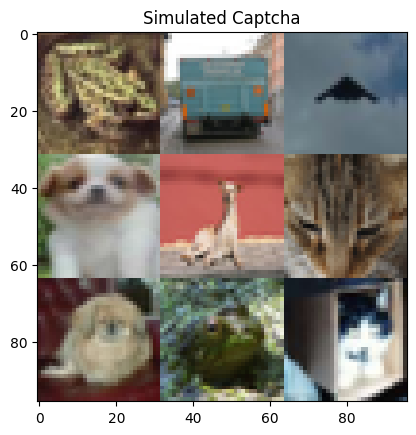

[b'frog' b'truck' b'airplane' b'dog' b'dog' b'cat' b'dog' b'frog' b'cat']


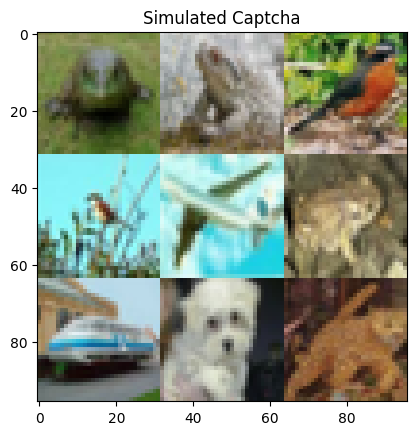

[b'frog' b'frog' b'bird' b'bird' b'airplane' b'frog' b'airplane' b'dog'
 b'cat']


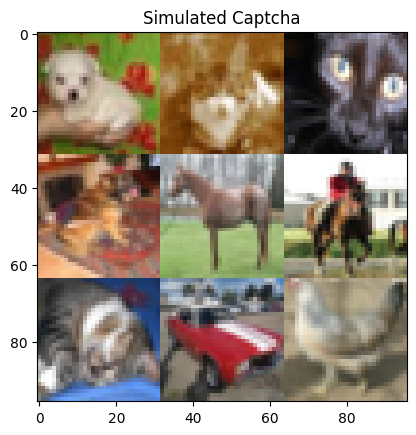

[b'dog' b'cat' b'cat' b'dog' b'horse' b'horse' b'cat' b'automobile'
 b'bird']


In [ ]:
### THIS CREATES ALL OF THE SIMULATED CAPTCHAS ###
concatenated_results = [create_simulated_captchas(batch, text_label_interpretations) for batch in train_batches]
captchas, num_labels, text_labels = [np.concatenate([t[i] for t in concatenated_results]) for i in range(3)]

test_captchas, test_num_labels, test_text_labels = create_simulated_captchas(test_batch, text_label_interpretations, True)
for label, captcha in zip(text_labels[1302:1303], captchas[1302:1303]):
  plt.imshow(captcha)
  plt.title("Simulated Captcha")
  plt.show()
  print(label)

# Model Work

With the simulated captchas created, we have two options. We can either make a resnet or some kind of classifier that outputs a 3 x 3 x 9 tensor of predictions (9 probabilities for each of the images in the 3 x 3 grid),

_OR_ we can split the captcha back into individual images _before_ we put it into the classifier, get the probabilities for each image separately, and then concatenate them all back together to display the output.

---
  
Note that we already have our data formatted in

captchas : (array of 96x96x3 images)

num_labels : (1x9 arrays with the correct numerical labels for each captcha)

text_labels : (human readable labels in a 3x3 grid for each captcha)

test_captchas, test_num_labels, and test_text_labels are exactly what they sound like they are. all of the above except for testing.

## Full Captcha Prediction (no splitting)

### Model Class Definition

In [ ]:
class Full_Captcha_Predictor(nn.Module):
    def __init__(self, num_sections, num_classes, start_frozen=False):
        super(Full_Captcha_Predictor, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

        if start_frozen:
            for param in self.model.parameters():
              param.requires_grad = False

        # Remove the original fully connected layer
        self.model.fc = nn.Identity()
        # Add a new fully connected layer for each section
        self.fc_sections = nn.ModuleList([nn.Linear(2048, num_classes, bias=True) for _ in range(num_sections)])

    def unfreeze(self, n_layers):
      for num, (name, param) in enumerate(self.model.named_parameters()):
        if num >= n_layers:
          param.requires_grad = True

    def forward(self, x):
      x = self.model(x)
      # Forward pass through each section's fully connected layer
      section_outputs = [fc(x) for fc in self.fc_sections]
      return section_outputs

    def eval(self):
      self.model.eval()

    def train(self):
      self.model.train()

### testing defaults

This part is testing the default resnet with default pretrained weights. you can fully ignore it

In [ ]:
# This is just a test of classification with the default resnet50 imagenet1k_v2 weights
weights = models.ResNet50_Weights.IMAGENET1K_V2
full_captcha_predictor = models.resnet50(weights=weights)

full_captcha_predictor.eval() # This puts the model in inference mode, call .train() to train

t = torch.tensor(image_reshaped, dtype=torch.float32)
t = t.unsqueeze(0)
t = t.permute(0, 3, 1, 2)
prediction = full_captcha_predictor(t).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(category_name, score)
# It sucks... it is supposed to be a truck

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 43.3MB/s]


book jacket 1.0


This part is testing default untrained full prediction model, it was just to make sure the shapes worked out and that we could run inference the way we want to.

In [ ]:
### IMPORTANT WHEN RUNNING INFERENCE ###
# THE DEFAULT RESNET INPUT LAYERS EXPECT AN INPUT OF (BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH)
# IF YOU ARE GIVING ONE INDIVIDUAL IMAGE EX 32 X 32 X 3, YOU MUST FIRST UNSQUEEZE(0)
# THEN USE .PERMUTE(0, 3, 1, 2) TO MAKE IT THE RIGHT SHAPE
########################################
c = torch.tensor(captchas[0], dtype=torch.float32)
c = c.unsqueeze(0)
c = c.permute(0, 3, 1, 2)
captcha_test_model = Full_Captcha_Predictor(9, 10) # there are 9 sections that need predictions with 10 classes each
captcha_test_model.eval()
# predictions will be a tensor 9 x 10 x 1 (10 probabilities per prediction)
predictions = captcha_test_model(c)
# we change it from log probs to a softmaxed probabilities and squeeze extra dim
predictions = [prediction.squeeze(0).softmax(0) for prediction in predictions]
# instead of sampling we take the argmax
class_ids = [prediction.argmax().item() for prediction in predictions]
# get the scores for the argmax
scores = [prediction[id].item() for id, prediction in zip(class_ids, predictions)]
# map the argmaxes to human readable category names
category_names = [text_label_interpretations[class_id] for class_id in class_ids]
for category_name, score in zip(category_names, scores):
  print(category_name, score)

b'ship' 0.9665165543556213
b'airplane' 0.9999964237213135
b'bird' 0.6698140501976013
b'deer' 0.9992057681083679
b'cat' 0.46335163712501526
b'automobile' 0.5948367714881897
b'cat' 0.9611849188804626
b'truck' 0.9997021555900574
b'bird' 0.9821805953979492


### Training Code

In [ ]:
def accuracy(y_hat, y_truth):
    preds = torch.argmax(y_hat, dim=1)
    acc = torch.mean((preds == y_truth).float())
    return acc

def evaluate(model, objective, val_loader, device):
    val_losses = []
    val_accs = []
    # model.eval() so that batchnorm and dropout work in eval mode
    model.eval()
    # torch.no_grad() because we aren't looking for saving gradients here
    with torch.no_grad():
        for x, y_truth in val_loader:

            x, y_truth = x.to(device), y_truth
            x = x.permute(0, 3, 1, 2)
            one_hot_encoded = torch.eye(10)[y_truth.long()]
            y_truth = one_hot_encoded.to(device)
            y_hat = model(x)
            y_hat = torch.stack(y_hat).permute(1, 0, 2)
            val_loss = objective(y_hat, y_truth)
            val_acc = accuracy(y_hat, y_truth)

            val_losses.append(val_loss.item())
            val_accs.append(val_acc)

    model.train() # put it back into train mode so the loop doesn't crash

    return torch.mean(torch.Tensor(val_losses)), torch.mean(torch.Tensor(val_accs))

In [ ]:
### HYPERPARAMETERS ### my best ones so far are lr = .0001, batch=32, epochs=7, test_steps=868
lr = .0001
batch_size = 32
epochs = 7
test_steps = 868
#######################

final_captcha = Full_Captcha_Predictor(9, 10, start_frozen=False).to(device)
final_captcha.train()
optimizer = optim.Adam(final_captcha.parameters(), lr=lr, weight_decay=1e-1)
objective = nn.CrossEntropyLoss()

captcha_dataset = CaptchaDataset(captchas, num_labels)
captcha_test_dataset = CaptchaDataset(np.array(test_captchas), np.array(test_num_labels))

train_dataloader = DataLoader(captcha_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(captcha_test_dataset)

losses = []
accs = []
val_losses = []
val_accs = []

total_steps = 0
for epoch in range(epochs):
  progress_bar = tqdm(train_dataloader, desc="Loss")
  for x, y_truth in progress_bar:
    x = x.to(device)
    x = x.permute(0, 3, 1, 2)
    # turn y_truth into a 3d tensor with one hot encoded values
    one_hot_encoded = torch.eye(10)[y_truth.long()]
    y_truth = one_hot_encoded.to(device)
    predictions = final_captcha(x)
    # predictions is a list of tensors, to make it comparable to the y_truth we must concatenate them with stack
    predictions = torch.stack(predictions).permute(1, 0, 2)
    # train_acc = accuracy(predictions, y_truth) <- this needs to be fixed
    # accs.append(train_acc.cpu()) <- once the above is fixed this can be uncommented
    loss = objective(predictions, y_truth)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_steps += 1
    if total_steps % test_steps == 0:
      val_loss, val_acc = evaluate(final_captcha, objective, test_dataloader, device)
      val_losses.append(val_loss.item())
      val_accs.append(val_acc.cpu()) # <- pretty sure this doesn't calculate accuracy correctly rn
    progress_bar.set_description(f"Epoch: {epoch}\tLoss: {loss.item()}")

    losses.append(loss.item())

Epoch: 14	Loss: 1.2610712051391602: 100%|██████████| 174/174 [00:23<00:00,  7.41it/s]


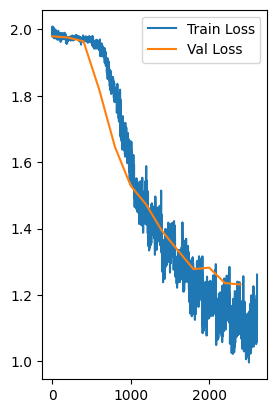

In [ ]:
# plt.subplot(121)
# plt.plot(np.arange(13020, step=test_steps), val_accs, label='Val Accuracy') # pretty sure this is not correct (see my above comment in the training loop)
# # especially given that the random one we picked below gets like 70-80% accuracy and this plot shows 10% accuracy
# plt.legend()
plt.subplot(122)
plt.plot(np.arange(len(losses)), losses, label='Train Loss')
plt.plot(np.arange(13020, step=test_steps), val_losses, label='Val Loss') # 13020 just makes it so that there are 15 spots for the 15 val_losses that we gathered
plt.legend()
plt.show()

Sam's Findings
- no difference in loss between resnet50 and 152 (haven't tested with latest hyperparameters)
- lowest loss achieved so far is .86 after 7 epochs (these parameters lr = .0001, batch_size = 32, epochs = 7)

array([[b'automobile', b'airplane', b'automobile'],
       [b'dog', b'horse', b'automobile'],
       [b'airplane', b'cat', b'automobile']], dtype='|S10')

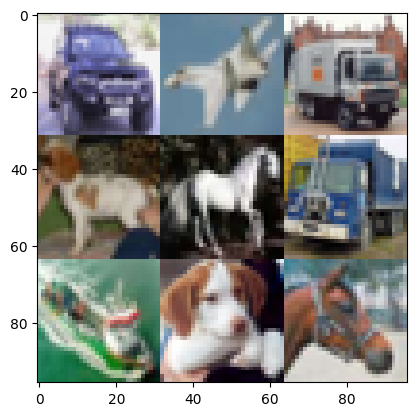

In [ ]:
# This is just a quick example of a test captcha being passed through. the predicted labels are shown above the photo
final_captcha.eval() # put it in eval mode
test_cap, _ = captcha_test_dataset[1] # we don't need the true labels so _
plt.imshow(test_cap.int().numpy()) # it needs to be integer from float, and we are going to use numpy not torch tensor
test_cap = test_cap.unsqueeze(0).permute(0, 3, 1, 2).to(device) # gotta reorganize the dimensions

predictions = final_captcha(test_cap)
predicted_labels = [prediction.argmax().item() for prediction in predictions]
text_labels = [text_label_interpretations[label] for label in predicted_labels] # get the text predictions
text_labels = np.array(text_labels)
text_labels.reshape(3, 3) # reshape it so it looks like the captcha

### Demonstration

In [ ]:
# generate a couple captchas, but specify like "select all automobiles" or something like that
# then show the output by plotting the captcha but highlighting the squares that it thinks are the item in question

## Splitting and reconcatenation prediction

In [ ]:
### make a class for this model

In [ ]:
#code for pretrained models from pytorch documentation:
# weights=models.ResNet50_Weights.IMAGENET1K_V2 #could also use default weights, or no specified weights

# full_captcha_predictor = models.resnet50(weights=weights)

# model.train()

# preprocess = weights.transforms()
# img_transformed = preprocess(img)

# batch = preprocess(img).unsqueeze(0)

# prediction = model(batch).squeeze(0).softmax(0)
# class_id = prediction.argmax().item()
# score = prediction[class_id].item()
# category_name = weights.meta["categories"][class_id]
# print(f"{category_name}: {100 * score}%")

#Text Classifying Model

# Dataloader

In [ ]:
def create_text_captcha_with_labels(dataset, test=False):
    images = []
    labels = []
    data_size_80 = (int)(len(dataset) * 0.8)

    if not test:
        for i in range(data_size_80):
            image, label = dataset[i]
            images.append(image)
            labels.append(label)
    else:
        for i in range(data_size_80, len(dataset)):
            image, label = dataset[i]
            images.append(image)
            labels.append(label)
    images = [np.array(image) for image in images]
    return images, labels

# the labels need to be one hot encoded for the model to read and classify
def one_hot_labels(labels):
    all_characters = string.ascii_lowercase + string.digits  # all letters of the alphabet and numbers 0-9
    vocab = {char: idx for idx, char in enumerate(all_characters)}

    label_sequences = [[vocab[char] for char in label] for label in labels]

    num_classes = len(all_characters)
    one_hot_labels = [one_hot(torch.tensor(seq), num_classes=num_classes) for seq in label_sequences]


    return one_hot_labels

In [ ]:
class TextCaptchaDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):

      self.data = torch.from_numpy(np.array(numpy_data, dtype=np.float32))
      self.labels = one_hot_labels(numpy_labels)
      self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        # if self.transform:
        #     sample = self.transform(sample)

        return sample, label

In [ ]:
class TextDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.images = os.listdir(directory)
        self.labels = [self.extract_label(file) for file in self.images]

    def extract_label(self, filename):
        label = filename.split('.')[0]
        return label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.directory, img_name)
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        return image, label

In [ ]:
dataset = TextDataset('./final_project_data/samples/samples')
text_captchas, text_labels = create_text_captcha_with_labels(dataset, test = False)
test_captchas, test_labels = create_text_captcha_with_labels(dataset, test=True)

In [ ]:
text_captcha_train_dataset = TextCaptchaDataset(text_captchas, text_labels)
text_captcha_test_dataset = TextCaptchaDataset(np.array(test_captchas), np.array(test_labels), True)

train_dataloader = DataLoader(text_captcha_train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(text_captcha_test_dataset, batch_size=10, shuffle=True)

In [ ]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

In [1]:
class Text_Captcha_Predictor(nn.Module):
    def __init__(self, num_sections, num_classes, start_frozen=False):
        super(Text_Captcha_Predictor, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        if start_frozen:
            for param in self.model.parameters():
              param.requires_grad = False

        # Remove the original fully connected layer
        # self.model.fc = nn.Identity()
        # Add a new fully connected layer for each section
        self.fc_sections = nn.ModuleList([nn.Linear(1000, num_classes, bias=True) for _ in range(num_sections)])

    def unfreeze(self, n_layers):
      for num, (name, param) in enumerate(self.model.named_parameters()):
        if num >= n_layers:
          param.requires_grad = True

    def forward(self, x):
      x = self.model(x)
      # Forward pass through each section's fully connected layer
      section_outputs = [fc(x) for fc in self.fc_sections]
      return section_outputs

    def eval(self):
      self.model.eval()

    def train(self):
      self.model.train()

# Training Metrics

In [ ]:
def evaluate(model, objective, test_dataloader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data, labels in test_dataloader:
            data = data.to(device).permute(0, 3, 1, 2)
            labels = labels.to(device).float()
            predictions = model(data)
            predictions = torch.stack(predictions).permute(1, 0, 2)

            loss = objective(predictions, labels)
            total_loss += loss.item()

            # _, predicted = predictions.max(1)
            # print(predicted.shape)
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    avg_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / total_predictions
    model.train()
    return avg_loss, accuracy

# Training

In [ ]:
lr = .001
epochs = 20
test_steps = 50
#######################

text_captcha = Text_Captcha_Predictor(num_sections = 5, num_classes=36, start_frozen=False).to(device)
text_captcha.train()
optimizer = optim.Adam(text_captcha.parameters(), lr=lr)
objective = nn.CrossEntropyLoss()

losses = []
accs = []
val_losses = []
val_accs = []

total_steps = 0
loss = torch.tensor(0)
for epoch in range(epochs):
    total_correct = 0
    total_samples = 0
  for batch_idx, (data, labels) in enumerate(tqdm(train_dataloader, desc=f"Epoch: {epoch}\tLoss: {loss.item()}")):
        data = data.to(device)
        data = data.permute(0, 3, 1, 2)

        labels = labels.to(device).float()
        predictions = text_captcha(data)
        predictions = torch.stack(predictions).permute(1, 0, 2)

        loss = objective(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_steps += 1
        losses.append(loss.item())

        # predictions = predictions.permute(1, 0, 2)
        # print(predictions.shape)
        # predictions = [prediction.squeeze(0).softmax(0) for prediction in predictions]
        # print(len(predictions))
        # # print(predictions)
        # # print(predictions)
        # # instead of sampling we take the argmax
        # class_ids = [prediction.argmax().item() for prediction in predictions]
        # print(class_ids)

        # print(labels)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

        total_steps += 1
        losses.append(loss.item())

        if total_steps % test_steps == 0:
            val_loss, val_acc = evaluate(text_captcha, objective, test_dataloader, device)
            val_losses.append((total_steps, val_loss))
            val_accs.append(val_acc)

    # Calculate accuracy for the epoch
    epoch_accuracy = total_correct / total_samples
    accs.append(epoch_accuracy)

# Plotting

In [ ]:
print(f"Length of val_losses: {len(val_losses)}")
print(f"Length of val_accs: {len(val_accs)}")

expected_validation_steps = epochs * len(train_dataloader) // test_steps
print(f"Expected number of validation steps: {expected_validation_steps}")
# Create x-axis values. Assuming validation metrics are recorded after every 'test_steps' training steps
x_values = np.arange(test_steps, epochs * test_steps + 1, step=test_steps)
x_values = np.arange(68)

# Check if x_values aligns with the length of val_losses and val_accs
if len(x_values) == len(val_losses):
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.plot(np.arange(len(losses)), losses, label='Training Loss')

    # Plot Validation Loss
    steps, val_loss = zip(*val_losses)
    plt.plot(steps, val_loss, label='Validation Loss', color='orange')

    # Adding labels and title
    plt.xlabel('Training Steps')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()

    plt.show()
else:
    print("Error: Mismatch in the length of loss metrics")

In [ ]:
# Check if x_values aligns with the length of val_losses and val_accs
if len(x_values) == len(val_losses):
    plt.figure(figsize=(12, 5))

    # Plot Training Accuracy
    plt.plot(np.arange(len(accs)), accs, label='Training Accuracy')

    # Plot Validation Accuracy
    steps, val_loss = zip(*val_losses)
    plt.plot(steps, val_accs, label='Validation Accuracy', color='orange')


    # Adding labels and title
    plt.xlabel('Training Steps')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Time')
    plt.legend()

    plt.show()

else:
    print("Error: Mismatch in the length of accuracy metrics")

In [ ]:
for i in range(10):
    c = torch.tensor(text_captchas[i], dtype=torch.float32)
    c = c.unsqueeze(0)
    c = c.permute(0, 3, 1, 2).to(device)
    text_captcha.eval()
    # predictions will be a tensor 5 x 36 x 1 (36 probabilities per prediction)
    predictions = text_captcha(c)
    # print(predictions)
    # we change it from log probs to a softmaxed probabilities and squeeze extra dim
    predictions = [prediction.squeeze(0).softmax(0) for prediction in predictions]
    # print(predictions)
    # instead of sampling we take the argmax
    class_ids = [prediction.argmax().item() for prediction in predictions]
    # get the scores for the argmax
    scores = [prediction[id].item() for id, prediction in zip(class_ids, predictions)]
    # map the argmaxes to human readable letters and numbers

    all_characters = string.ascii_lowercase + string.digits  # all letters of the alphabet and numbers 0-9
    vocab = {idx: char for idx, char in enumerate(all_characters)}

    predicted_captcha = ''.join([vocab[class_id] for class_id in class_ids])
    print(predicted_captcha)
    im = Image.fromarray(text_captchas[i].astype('uint8'), 'RGB')
    im.show(im)